In [7]:
import pandas as pd
import os.path as op
import numpy as np
from os import listdir
import pingouin
import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/Volumes/mrenkeED/data/ds-dnumrisk'
subs= [int(f[4:]) for f in listdir(bids_folder) if f[0:3] == 'sub']

pati_save = '/Users/mrenke/data/ds-dnumrisk/interim_sum_data'

group_mapping = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/interim_sum_data/group_assignment_sub1-42.csv').set_index('subject')


In [8]:
from numrisk.utils.data import Subject
runs = range(1, 7)

subjects = [Subject(sub, bids_folder) for sub in subs]
behavior = [s.get_behavior_magjudge(runs = runs) for s in subjects]
behavior = pd.concat(behavior).sort_index(0)


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_9006/4025717983.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  behavior = pd.concat(behavior).sort_index(0)


In [80]:
from utils import get_decoding_info

split_data = 'run_123' # 'full'
pred = [get_decoding_info(sub,bids_folder=bids_folder,split_data=split_data) for sub in subs]
pred = pd.concat(pred)

/Volumes/mrenkeED/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect_run_123.denoise/sub-10/func/sub-10_ses-1_mask-NPC_R_space-T1w_pars.tsv
/Volumes/mrenkeED/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect_run_123.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv
/Volumes/mrenkeED/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect_run_123.denoise/sub-04/func/sub-04_ses-1_mask-NPC_R_space-T1w_pars.tsv
/Volumes/mrenkeED/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect_run_123.denoise/sub-38/func/sub-38_ses-1_mask-NPC_R_space-T1w_pars.tsv


In [31]:
from tqdm.contrib.itertools import product
from utils import get_decoding_info

n_voxels =  'select' #100 # 
data_variants = ['full', 'run_123', 'run_456']

pred = []
for (sub, split_data) in product(subs, data_variants):
    pred.append(get_decoding_info(sub, bids_folder=bids_folder, split_data=split_data, n_voxels = n_voxels))
pred = pd.concat(pred)

100%|██████████| 126/126 [00:03<00:00, 41.95it/s]


In [32]:
import pingouin
df = pred.join(behavior['log(n1)'], how='inner')

r = df.groupby(['subject','data']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r = r.reset_index(2,drop=True) # get rid of None-index with pearson entry


Text(0.5, 1.0, 'voxels: select')

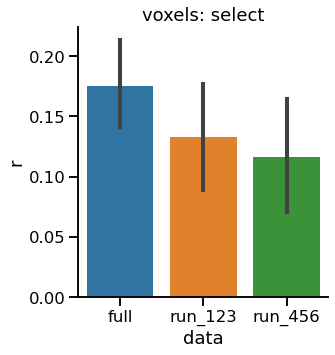

In [33]:
import seaborn as sns
sns.set_context('talk')
sns.catplot(data=r.reset_index(), y='r',x='data',kind='bar')#,errorbar = 'se'
plt.title(f'voxels: {n_voxels}')

In [27]:
# prepare & save 
temp = r['r'].unstack('data')

#temp.stack().to_frame('r').to_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv')) # save !

In [23]:
# load in 
temp = pd.read_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv')).set_index(['subject','data']).unstack('data')


Text(0.5, 1.0, 'voxels: 100 \n r=0.21, p= 0.28465')

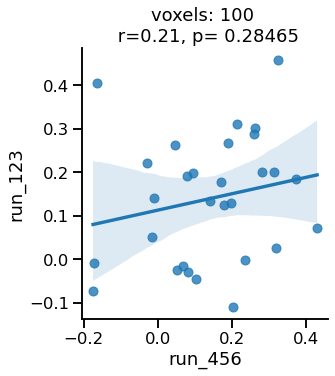

In [30]:
var1 = 'run_456'#'full' #'run_456' # 
var2 = 'run_123'
cor = pingouin.corr(temp[var1],temp[var2])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

sns.lmplot(data=temp, x=var1,y=var2)
plt.title(f'voxels: {n_voxels} \n r={r_}, p= {p}') 

In [35]:
behavior['n2'].max()

56.0

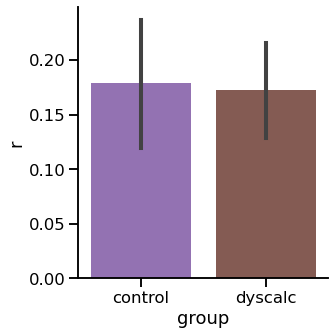

In [6]:
# group difference ?
palette = sns.color_palette()[4:]
sns.set_context('talk')

temp = pd.read_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv')).set_index(['subject','data'])
temp = temp.xs('full',0,'data')
temp =temp.join(group_mapping)
temp['group']= np.where(temp['group'] == 0, 'control', 'dyscalc')

sns.catplot(data=temp.reset_index(), y='r',x='group',kind='bar', palette = palette)#,errorbar = 'se'


## test-retest reliablity

In [101]:
import pingouin


pingouin.cronbach_alpha(data=temp.drop('full',axis=1))

(0.3614135913539054, array([-0.229,  0.668]))

In [93]:
temp.drop('full',axis=1).head()

data,run_123,run_456
subject,,
1,-0.098708,-0.173934
2,0.096463,0.111854
5,-0.004588,-0.068201
6,0.046835,0.088642
7,-0.051561,0.001348
